In [2]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

ensemble.cuda();
covs = []
for i in range(10):
    initial_beam = ensemble[i].beam()
    covs+= [torch.cov(initial_beam.data.T)]

covs = torch.stack(covs)
covs.shape



0
1
2
3
4
5
6
7
8
9


torch.Size([10, 6, 6])

In [14]:
xemittances = torch.det(covs[:,:2,:2]).sqrt()
yemittances = torch.det(covs[:,2:4,2:4]).sqrt()
print(f"enx {xemittances.mean()} +/- {xemittances.std()}")
print(f"eny {yemittances.mean()} +/- {yemittances.std()}")





enx 5.693962975783506e-06 +/- 2.01665372401294e-07
eny 8.181016710295808e-06 +/- 3.5934760944655864e-07


In [15]:
xemittances

tensor([5.1649e-06, 5.5585e-06, 5.6826e-06, 5.7658e-06, 5.8001e-06, 5.8100e-06,
        5.7693e-06, 5.7769e-06, 5.7970e-06, 5.8144e-06], device='cuda:0',
       grad_fn=<SqrtBackward0>)

In [16]:
yemittances

tensor([7.2719e-06, 7.8942e-06, 8.1700e-06, 8.2755e-06, 8.2912e-06, 8.2801e-06,
        8.3265e-06, 8.3774e-06, 8.4102e-06, 8.5130e-06], device='cuda:0',
       grad_fn=<SqrtBackward0>)

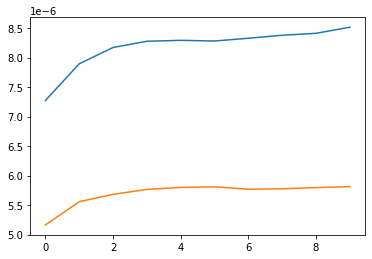

In [20]:
plt.plot(yemittances.cpu().detach())
plt.plot(xemittances.cpu().detach())